# In this project a forensic investigation into the tensorflow implementation the Word2vec models called Skip-gram and CBOW is carried out. 

Found the file wikipedia2text-extracted.txt.bz2
The verified file size is 18377035
Reading data...
Data size 3361041
Example words (start):  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end):  ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']

with window_size = 4:
    batch: ['set', 'set', 'set', 'set', 'set', 'set', 'set', 'set', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'messages', 'messages', 'messages', 'messages', 'messages', 'messages', 'messages', 'messages', 'aimed', 'aimed', 'aimed', 'aimed', 'aimed', 'aimed', 'aimed', 'aimed', 'at', 'at', 'at', 'at', 'at', 'at', 'at', 'at', 'influencing', 'influencing', 'influencing', 'influencing', 'influencing', 'influencing', 'influencing', 'influencing', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'opinions', 'opinions', 'opinions', 'opinions', 'opinions', 'opinions', 'opinions', 'opinions', 'or', 'or', 'or'

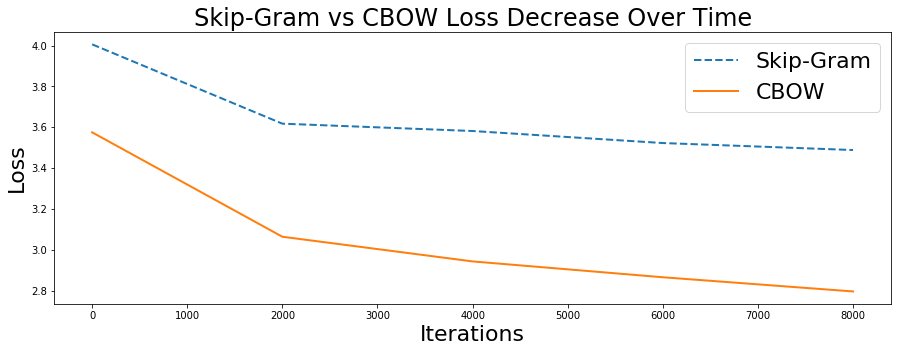

In [5]:
#Imports
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import bz2
from matplotlib import pylab
import nltk
import operator
from math import ceil
import csv


#Check File
def check_file(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
        print ('The file ' + filename + ' is not available. Download from https://www.evanjones.ca/software/wikipedia2text-extracted.txt.bz2')
  else:
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found the file ' + filename)
        print('The verified file size is %s' % statinfo.st_size)
  return filename


#Read File
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""

  with bz2.BZ2File(filename) as f:
    data = []
    file_string = f.read().decode('utf-8')
    file_string = nltk.word_tokenize(file_string)
    data.extend(file_string)
  return data



#Pre-Process File using NLTK

def read_data(filename):
  """
  Extract the first file enclosed in a zip file as a list of words
  and pre-processes it using the nltk python library
  """

  with bz2.BZ2File(filename) as f:

    data = []
    file_size = os.stat(filename).st_size
    chunk_size = 1024 * 1024 # reading 1 MB at a time as the dataset is moderately large
    print('Reading data...')
    for i in range(ceil(file_size//chunk_size)+1):
        bytes_to_read = min(chunk_size,file_size-(i*chunk_size))
        file_string = f.read(bytes_to_read).decode('utf-8')
        file_string = file_string.lower()
        # tokenizes a string to words residing in a list
        file_string = nltk.word_tokenize(file_string)
        data.extend(file_string)
  return data

# we restrict our vocabulary size to 50000
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
 
  # Gets only the vocabulary_size most common words as the vocabulary
  # All the other words will be replaced with UNK token
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()

  # Create an ID for each word by giving the current length of the dictionary
  # And adding that item to the dictionary
  for word, _ in count:
    dictionary[word] = len(dictionary)
   
  data = list()
  unk_count = 0
 
  # Traverse through all the text we have and produce a list
  # where each element corresponds to the ID of the word found at that index
  for word in words:
    # If word is in the dictionary use the word ID,
    # else use the ID of the special token "RARE"
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['RARE']
      unk_count = unk_count + 1
    data.append(index)
   
  # update the count variable with the number of UNK occurences
  count[0][1] = unk_count
 
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  # Make sure the dictionary is of size of the vocabulary
  assert len(dictionary) == vocabulary_size
   
  return data, count, dictionary, reverse_dictionary

#data_index = 0

def generate_batch_skip_gram(batch_size, window_size):
  # data_index is updated by 1 everytime we read a data point
  global data_index
   
  # two numpy arras to hold target words (batch)
  # and context words (labels)
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
   
  # span defines the total window size, where
  # data we consider at an instance looks as follows.
  # [ skip_window target skip_window ]
  span = 2 * window_size + 1
   
  # The buffer holds the data contained within the span
  buffer = collections.deque(maxlen=span)
 
  # Fill the buffer and update the data_index
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
 
  # This is the number of context words we sample for a single target word
  num_samples = 2*window_size

  # We break the batch reading into two for loops
  # The inner for loop fills in the batch and labels with
  # num_samples data points using data contained withing the span
  # The outper for loop repeat this for batch_size//num_samples times
  # to produce a full batch
  for i in range(batch_size // num_samples):
    k=0
    # avoid the target word itself as a prediction
    # fill in batch and label numpy arrays
    for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
      batch[i * num_samples + k] = buffer[window_size]
      labels[i * num_samples + k, 0] = buffer[j]
      k += 1
   
    # Everytime we read num_samples data points,
    # we have created the maximum number of datapoints possible
    # withing a single span, so we need to move the span by 1
    # to create a fresh new span
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels


# Using the pre-defined functions to prepare data for training
filename = check_file('wikipedia2text-extracted.txt.bz2', 18377035)
words = read_data(filename)
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Data size %d' % len(words))
print('Example words (start): ', words[:10])
print('Example words (end): ', words[-10:])
del words # This is to reduce memory usage.


for window_size in [4]:
    data_index = 0
    batch, labels = generate_batch_skip_gram(batch_size=128, window_size=window_size)
    print('\nwith window_size = %d:' %window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(128)])

batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
window_size = 4 # How many words to consider left and right.
num_sampled = 32 # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)



tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)



# Variables

# Embedding layer, contains the word embeddings
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Softmax Weights and Biases
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=0.5 / math.sqrt(embedding_size)))
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01))



# Model.
# Look up embeddings for a batch of inputs.
embed = tf.nn.embedding_lookup(embeddings, train_dataset)

# Compute the softmax loss, using a sample of the negative labels each time.
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(
        weights=softmax_weights, biases=softmax_biases, inputs=embed,
        labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size)
)

# Compute final embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm



# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)


# This step number should be changed to higher to achieve better training quality. Example: num_steps = 100001  
num_steps = 10000  # The training step is set low for testing purposes.
skip_losses = []

data_index = 0 # initialisation for the generate_batch_skip_gram()
test = 0
# ConfigProto is a way of providing various configuration settings
# required to execute the graph
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
  # Initialize the variables in the graph
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
 
  # Train the Word2vec model for num_step iterations
  for step in range(num_steps):
   
    # Generate a single batch of data
    batch_data, batch_labels = generate_batch_skip_gram(batch_size, window_size)
   
    # Populate the feed_dict and run the optimizer (minimize loss)
    # and compute the loss
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, loss_value = session.run([optimizer, loss], feed_dict=feed_dict)
   
    # Update the average loss variable
    average_loss += loss_value
   
    if (step+1) % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
     
      skip_losses.append(average_loss)
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step+1, average_loss))
      average_loss = 0
   
  skip_gram_final_embeddings = normalized_embeddings.eval()
 
# We will save the word vectors learned and the loss over time
# as this information is required later for comparisons
np.save('skip_embeddings',skip_gram_final_embeddings)

with open('skip_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(skip_losses)
   


# This is to demonstrate how the argsort() function works because it is used in  sorting the index of the softmax output below.

x = np.array([1.48,2.41,0.0,0.1])   # This return the index from the low to high number.
print (x.argsort())
x = -np.array([1.48,2.41,0.0,0.1])  # This return the index from the high to low number.
print (x.argsort())


# skip_gram_final_embeddings is the softmax output namely the probabilities
# The following code is to show a list of words nearest to a given word.

i=1 # let's say a word
valid_word = reverse_dictionary[i]
log = 'Given a word "%s", and the nearest words are --> ' % valid_word

top_k = 8 # To print the top 8 nearest words
nearest = (-skip_gram_final_embeddings[i,:]).argsort()[0:top_k]  # sort out the softmax probabilities in the higher to low order

for k in range(top_k):
    nearest_word = reverse_dictionary[nearest[k]]
    log = '%s%s,' % (log, nearest_word)
print(log)




def generate_batch_cbow(batch_size, window_size):
    # window_size is the amount of words we're looking at from each side of a given word
    # creates a single batch
   
    # data_index is updated by 1 everytime we read a set of data point
    global data_index

    # span defines the total window size, where
    # data we consider at an instance looks as follows.
    # [ skip_window target skip_window ]
    # e.g if skip_window = 2 then span = 5
    span = 2 * window_size + 1 # [ skip_window target skip_window ]

    # two numpy arras to hold target words (batch)
    # and context words (labels)
    # Note that batch has span-1=2*window_size columns
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
   
    # The buffer holds the data contained within the span
    buffer = collections.deque(maxlen=span)

    # Fill the buffer and update the data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # Here we do the batch reading
    # We iterate through each batch index
    # For each batch index, we iterate through span elements
    # to fill in the columns of batch array
    for i in range(batch_size):
        target = window_size  # target label at the center of the buffer
        target_to_avoid = [ window_size ] # we only need to know the words around a given word, not the word itself

        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(span):
            # ignore the target word when creating the batch
            if j==span//2:
                continue
            batch[i,col_idx] = buffer[j]
            col_idx += 1
        labels[i, 0] = buffer[target]

        # Everytime we read a data point,
        # we need to move the span by 1
        # to create a fresh new span
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    return batch, labels



for window_size in [2]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
   


batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.

# How many words to consider left and right.
# Skip gram by design does not require to have all the context words in a given step
# However, for CBOW that's a requirement, so we limit the window size
window_size = 2

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.


tf.reset_default_graph()

# Training input data (target word IDs). Note that it has 2*window_size columns
train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*window_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)



# Variables.

# Embedding layer, contains the word embeddings
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))

# Softmax Weights and Biases
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=0.5 / math.sqrt(embedding_size),dtype=tf.float32))
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01))




# Model.
# Look up embeddings for a batch of inputs.
# Here we do embedding lookups for each column in the input placeholder
# and then average them to produce an embedding_size word vector
stacked_embedings = None
print('Defining %d embedding lookups representing each word in the context'%(2*window_size))
for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])        
    x_size,y_size = embedding_i.get_shape().as_list()
    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())
mean_embeddings =  tf.reduce_mean(stacked_embedings,2,keepdims=False)
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())

# Compute the softmax loss, using a sample of the negative labels each time.
# inputs are embeddings of the train words
# with this loss we optimize weights, biases, embeddings
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))




# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)


# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm



# This step number should be changed to higher to achieve better training quality. Example: num_steps = 100001
num_steps = 10000  # The training step is set low for testing purposes.
cbow_losses = []

data_index = 0 # initialisation for the generate_batch_cbow()

# ConfigProto is a way of providing various configuration settings
# required to execute the graph
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
   
    # Initialize the variables in the graph
    tf.global_variables_initializer().run()
    print('Initialized')
   
    average_loss = 0
   
    # Train the Word2vec model for num_step iterations
    for step in range(num_steps):
       
        # Generate a single batch of data
        batch_data, batch_labels = generate_batch_cbow(batch_size, window_size)
       
        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, loss_value = session.run([optimizer, loss], feed_dict=feed_dict)
       
        # Update the average loss variable
        average_loss += loss_value
       
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            cbow_losses.append(average_loss)
            print('Average loss at step %d: %f' % (step+1, average_loss))
            average_loss = 0
           
    cbow_final_embeddings = normalized_embeddings.eval()
   

np.save('cbow_embeddings',cbow_final_embeddings)

with open('cbow_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_losses)

   
skip_loss_path = os.path.join('skip_losses.csv')
with open(skip_loss_path, 'rt') as f:
    reader = csv.reader(f,delimiter=',')
    for r_i,row in enumerate(reader):
        if r_i == 0:
            skip_gram_loss =  [float(s) for s in row]
           

cbow_loss_path = os.path.join('cbow_losses.csv')
with open(cbow_loss_path, 'rt') as f:
    reader = csv.reader(f,delimiter=',')
    for r_i,row in enumerate(reader):
        if r_i == 0:
            cbow_loss =  [float(s) for s in row]
           

pylab.figure(figsize=(15,5))  # in inches

# Define the x axis
x = np.arange(len(skip_gram_loss))*2000

# Plot the skip_gram_loss (loaded from chapter 3)
pylab.plot(x, skip_gram_loss, label="Skip-Gram",linestyle='--',linewidth=2)    
# Plot the cbow_loss (loaded from chapter 3)
pylab.plot(x, cbow_loss, label="CBOW",linewidth=2)

# Set some text around the plot
pylab.title('Skip-Gram vs CBOW Loss Decrease Over Time',fontsize=24)
pylab.xlabel('Iterations',fontsize=22)
pylab.ylabel('Loss',fontsize=22)
pylab.legend(loc=1,fontsize=22)

# use for saving the figure if needed
pylab.savefig('loss_skipgram_vs_cbow.png')
pylab.show()